In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the stock price dataset
stock_data = pd.read_csv(r"C:\Users\bhara\Documents\Main flow internship\Task 7\stock_prices.csv")

# Display basic information and the first few rows of the dataset
stock_data.info(), stock_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2876 entries, 0 to 2875
Columns: 480 entries, Date to ZNGA
dtypes: float64(479), object(1)
memory usage: 10.5+ MB


(None,
          Date          A         AA      AAPL  ABBV        ABC       ABT  \
 0  2003-07-31  13.790836  53.019848  1.019303   NaN  12.739487  9.022574   
 1  2003-08-01  13.676599  51.759747  1.002379   NaN  12.579965  8.859362   
 2  2003-08-04  13.682946  52.256149  1.025589   NaN  12.398233  8.850165   
 3  2003-08-05  13.219654  51.206055  0.985455   NaN  12.111500  8.700747   
 4  2003-08-06  13.060995  50.783653  0.949190   NaN  11.752071  8.873152   
 
          ACN       ADBE        ADI  ...       XEL         XL       XLNX  \
 0  15.108545  16.333433  26.962475  ...  7.946304  53.450195  19.403030   
 1  15.816516  16.268559  28.070812  ...  7.858501  50.491951  19.898077   
 2  15.660917  16.523066  28.227112  ...  7.803621  51.500431  19.838972   
 3  15.147444  16.183720  27.132978  ...  7.699356  51.856777  19.225708   
 4  14.937387  15.749559  27.175615  ...  7.748745  52.643398  19.151808   
 
          XOM       XRAY        XRX  XYL       YUM       ZION  ZNGA  
 

In [3]:
# Step 1: Preprocess the stock data
# Convert 'Date' to datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Set 'Date' as the index
stock_data.set_index('Date', inplace=True)

# Choose one stock for prediction, e.g., AAPL (Apple Inc.)
# Drop rows with missing values for AAPL
aapl_data = stock_data[['AAPL']].dropna()

# Display summary
aapl_data.info(), aapl_data.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2876 entries, 2003-07-31 to 2014-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2876 non-null   float64
dtypes: float64(1)
memory usage: 44.9 KB


(None,
                 AAPL
 Date                
 2003-07-31  1.019303
 2003-08-01  1.002379
 2003-08-04  1.025589
 2003-08-05  0.985455
 2003-08-06  0.949190)

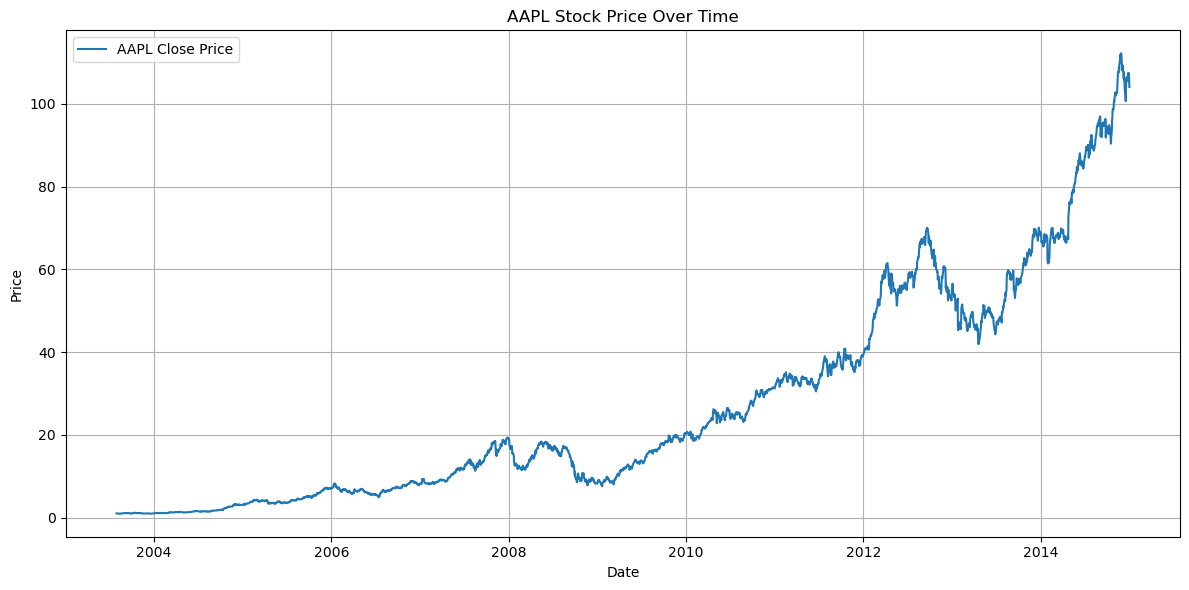

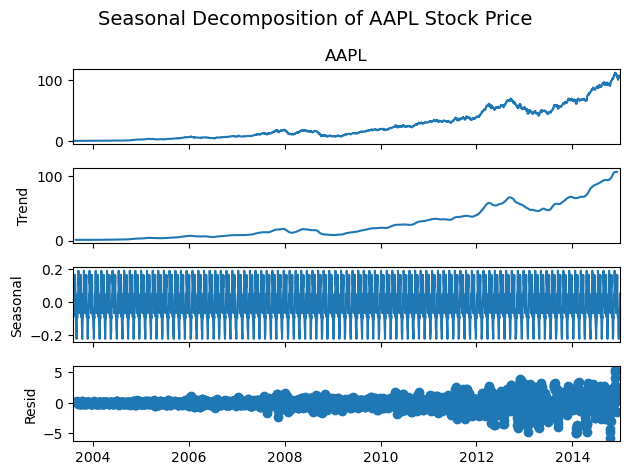

In [5]:
# Plot the AAPL time series
plt.figure(figsize=(12, 6))
plt.plot(aapl_data, label='AAPL Close Price')
plt.title('AAPL Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Perform seasonal decomposition (using monthly frequency)
decomposition = seasonal_decompose(aapl_data['AAPL'], model='additive', period=30)

# Plot decomposition
decomposition.plot()
plt.suptitle('Seasonal Decomposition of AAPL Stock Price', fontsize=14)
plt.tight_layout()
plt.show()


In [7]:
# Create lag and rolling features for AAPL
aapl_features = aapl_data.copy()

# Lag feature: previous day's price
aapl_features['lag_1'] = aapl_features['AAPL'].shift(1)

# Rolling window features
aapl_features['rolling_mean_7'] = aapl_features['AAPL'].rolling(window=7).mean()
aapl_features['rolling_mean_30'] = aapl_features['AAPL'].rolling(window=30).mean()

# Drop rows with NaNs introduced by lag/rolling
aapl_features.dropna(inplace=True)


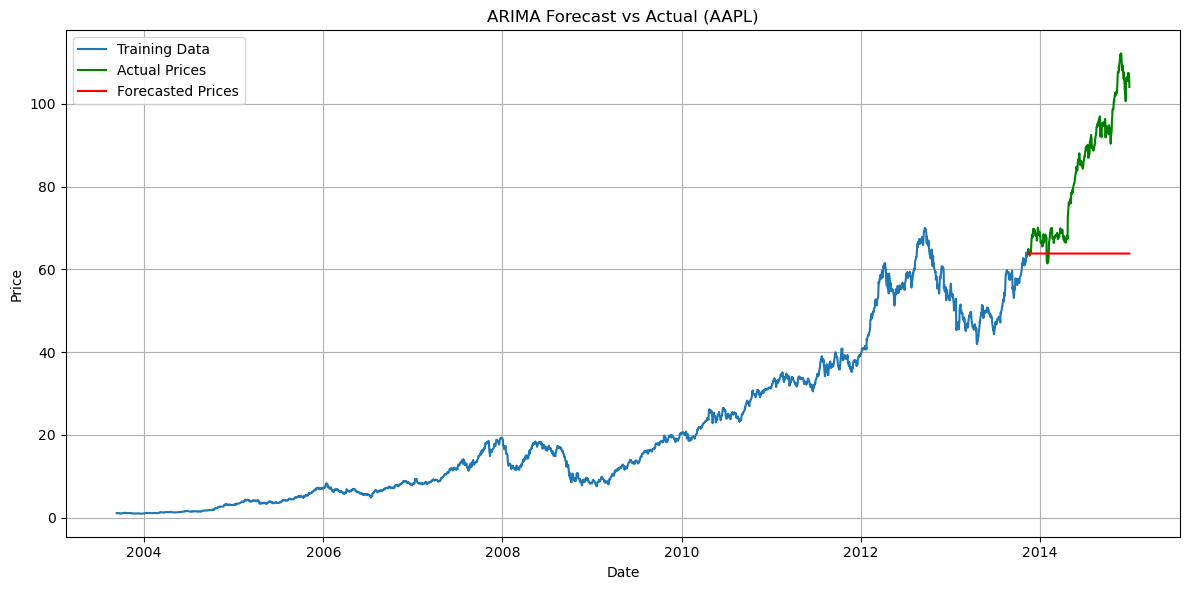

(19.41684506252911, 24.20887848405175, nan)

In [9]:
# Use only the 'AAPL' column for ARIMA modeling
aapl_series = aapl_features['AAPL']

# Split into training and testing sets (e.g., 90% train, 10% test)
split_index = int(len(aapl_series) * 0.9)
train, test = aapl_series[:split_index], aapl_series[split_index:]

# Fit an ARIMA model (initially using p=5, d=1, q=0)
model = ARIMA(train, order=(5, 1, 0))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Evaluation metrics
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Prices', color='green')
plt.plot(test.index, forecast, label='Forecasted Prices', color='red')
plt.title('ARIMA Forecast vs Actual (AAPL)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

(mae, rmse, mape)